# Assignment 2B: Ranking

This notebook contains the skeleton for training a model and then applying it to produce a document ranking.

## Loading the precomputed features

The code below loads the precomputed features and combines them into feature vectors for query-document pairs.

In [1]:
import json
import pandas as pd
from pprint import pprint
from tqdm import tqdm

RANDOM_STATE = 42

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def load_features(features_to_load):
    feature_list = []
    
    for feature in features_to_load:
        print(f'Loading features from {feature["file"]}')
        with open(feature['file']) as f:
              index = ['QueryId', 'DocumentId']
              new_feature = pd.read_csv(f, index_col=index)[feature['select']]
              feature_list.append(new_feature)

    features = pd.concat(feature_list, axis='columns')
    return features

In [3]:
def load_qrels(path):
    with open(path) as f:
        qrels = pd.read_csv(f, index_col=['QueryId', 'DocumentId'])
    return qrels

In [4]:
def normalize_dataframe(df, strategy='macro'):
    if strategy == 'micro':
        return df.groupby('QueryId').transform(lambda x: (x - x.mean()) / x.std())
    elif strategy == 'macro':
        return (df - df.mean()) / df.std()

In [5]:
# Specify the features to be loaded from each file

features = dict(train=[], test=[])

for mode in ['train', 'test']:
    features[mode] = [
    {
        'file': f'data/{mode}_features_pagerank.csv',
        'select': ['pagerank_score']
    },
    {
        'file': f'data/{mode}_features_field_length.csv',
        'select': ['content_length', 'title_length', 'anchors_length']
    },
    {
        'file': f'data/{mode}_features_tf.csv',
        'select': ['TF_title_sum', 'TF_content_sum', 'TF_anchors_sum', 'TF_title_mean', 'TF_content_mean', 'TF_anchors_mean', 'TF_title_min', 'TF_content_min', 'TF_anchors_min', 'TF_title_max', 'TF_content_max', 'TF_anchors_max', 'normalized_TF_title_sum', 'normalized_TF_content_sum', 'normalized_TF_anchors_sum', 'normalized_TF_title_mean', 'normalized_TF_content_mean', 'normalized_TF_anchors_mean', 'normalized_TF_title_min', 'normalized_TF_content_min', 'normalized_TF_anchors_min', 'normalized_TF_title_max', 'normalized_TF_content_max', 'normalized_TF_anchors_max']
    },
    {
        'file': f'data/{mode}_features_tfidf.csv',
        'select': ['TFIDF_title_sum', 'TFIDF_content_sum', 'TFIDF_anchors_sum', 'TFIDF_title_mean', 'TFIDF_content_mean', 'TFIDF_anchors_mean', 'TFIDF_title_min', 'TFIDF_content_min', 'TFIDF_anchors_min', 'TFIDF_title_max', 'TFIDF_content_max', 'TFIDF_anchors_max', 'normalized_TFIDF_title_sum', 'normalized_TFIDF_content_sum', 'normalized_TFIDF_anchors_sum', 'normalized_TFIDF_title_mean', 'normalized_TFIDF_content_mean', 'normalized_TFIDF_anchors_mean', 'normalized_TFIDF_title_min', 'normalized_TFIDF_content_min', 'normalized_TFIDF_anchors_min', 'normalized_TFIDF_title_max', 'normalized_TFIDF_content_max', 'normalized_TFIDF_anchors_max']
    },
    {
        'file': f'data/{mode}_features_qcoverage.csv',
        'select': ['title_query_coverage', 'content_query_coverage', 'anchors_query_coverage', 'normalized_title_query_coverage', 'normalized_content_query_coverage', 'normalized_anchors_query_coverage']
    },
    {
        'file': f'data/{mode}_features_bm25.csv',
        'select': ['bm25_title', 'bm25_content', 'bm25_anchors',]
    },
    {
        'file': f'data/{mode}_features_lm.csv',
        'select': ['lm_title', 'lm_content', 'lm_anchors']
    },
    {
        'file': f'data/{mode}_features_qlen.csv',
        'select': ['query_length']
    }
]


train_features = load_features(features['train'])
full_feature_list = list(train_features.columns)

test_features = load_features(features['test'])
assert full_feature_list == list(test_features.columns)

Loading features from data/train_features_pagerank.csv
Loading features from data/train_features_field_length.csv
Loading features from data/train_features_tf.csv
Loading features from data/train_features_tfidf.csv
Loading features from data/train_features_qcoverage.csv
Loading features from data/train_features_bm25.csv
Loading features from data/train_features_lm.csv
Loading features from data/train_features_qlen.csv
Loading features from data/test_features_pagerank.csv
Loading features from data/test_features_field_length.csv
Loading features from data/test_features_tf.csv
Loading features from data/test_features_tfidf.csv
Loading features from data/test_features_qcoverage.csv
Loading features from data/test_features_bm25.csv
Loading features from data/test_features_lm.csv
Loading features from data/test_features_qlen.csv


Now that the features are loaded, we can create the feature vectors.

In [6]:
qrels = load_qrels('data/qrels.csv')

train_data = normalize_dataframe(train_features)
train_data = train_data.join(qrels, how='inner')
train_data = train_data.astype({'Relevance' : 'int'})

test_data = normalize_dataframe(test_features)

In [7]:
train_data

,,pagerank_score,content_length,title_length,anchors_length,TF_title_sum,TF_content_sum,TF_anchors_sum,TF_title_mean,TF_content_mean,TF_anchors_mean,...,normalized_content_query_coverage,normalized_anchors_query_coverage,bm25_title,bm25_content,bm25_anchors,lm_title,lm_content,lm_anchors,query_length,Relevance
QueryId,DocumentId,,,,,,,,,,,,,,,,,,,,,
202,clueweb12-1415wb-40-03869,-0.070611,-0.383443,-0.220289,-0.033849,-0.559190,-0.556806,-0.103596,-0.362837,-0.516691,-0.110389,...,0.152671,-0.598994,-0.880652,1.357033,-0.593207,-1.313133,-0.423786,-1.448554,0.040855,0
225,clueweb12-0011wb-04-18537,1.178111,0.864492,-0.767275,1.868637,-0.559190,1.762469,-0.103596,-0.362837,2.430633,-0.110389,...,0.152671,-0.598994,-0.880652,-1.475224,-0.593207,0.570674,1.023473,0.056643,-0.980515,0
203,clueweb12-0103wb-27-32640,-0.132254,-0.416052,0.509025,-0.189385,0.371242,-0.523515,-0.103596,-0.362837,-0.489146,-0.110389,...,0.152671,-0.598994,0.840636,-0.005711,-0.593207,0.690897,-0.065789,1.177740,0.040855,0
204,clueweb12-0207wb-85-00335,-0.132254,-0.426404,0.691354,-0.070930,1.766890,0.153403,-0.036874,2.342886,0.419842,-0.014294,...,0.152671,0.912955,1.136383,-1.284645,0.386286,1.425860,1.143782,0.403383,-0.980515,1
239,clueweb12-0305wb-88-27381,0.312441,-0.459530,-0.402618,-0.158484,1.301674,-0.412545,-0.060082,0.990024,-0.461601,-0.084181,...,0.152671,0.156981,2.917329,1.664387,0.726185,0.350264,-0.898044,-1.155950,1.062225,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,clueweb12-0006wb-01-33967,0.068588,-0.623092,-0.402618,-0.189385,0.371242,-0.556806,-0.103596,0.990024,-0.461601,-0.110389,...,0.152671,-0.598994,2.027555,0.661408,-0.593207,1.406189,0.948221,1.177740,-0.980515,0
205,clueweb12-1806wb-56-00524,-0.132254,-0.247314,-0.037961,-0.189385,0.371242,-0.312671,-0.103596,-0.362837,-0.323875,-0.110389,...,0.152671,-0.598994,1.136153,-0.117098,-0.593207,0.392627,-0.150764,1.177740,0.040855,0
216,clueweb12-1708wb-22-00648,-0.132254,-0.552698,0.144368,-0.172904,0.371242,-0.345963,-0.103596,-0.362837,-0.351420,-0.110389,...,0.152671,-0.598994,1.141201,0.633636,-0.593207,0.630709,0.256232,-0.949126,0.040855,0


## Dealing with class imbalance

Our dataset suffers from class imbalance : very few documents have a high relevance label. We can upsample the minority classes to balance our dataset.

In [8]:
train_data['Relevance'].value_counts()

 0    843
 1    331
 2     89
 3     11
-2      8
Name: Relevance, dtype: int64

In [9]:
from sklearn.utils import resample

max_samples = train_data['Relevance'].value_counts().max()

subclasses = []

for relevance in train_data['Relevance'].unique():
    subclass = train_data[train_data['Relevance'] == relevance]
    resampled_subclass = resample(subclass, replace=True, n_samples=max_samples, random_state=RANDOM_STATE)
    subclasses.append(resampled_subclass)

balanced_train_data = pd.concat(subclasses)

In [10]:
balanced_train_data['Relevance'].value_counts()

 3    843
 2    843
-2    843
 1    843
 0    843
Name: Relevance, dtype: int64

## Training a model

Training needs to be done differently based on the scenario:

  * **Scenario 1**: The model is trained using cross-validation, that is on 4/5 of queries, then applied on the remaining 1/5 of queries (repeated 5 times).
  * **Scenario 2**: The model is trained on all available training data.
  
The feature vectors at this point are already created. These should contain both (a) the training queries and (b) the queries on which you want to apply your model.

Train your model on queries (a). For that you'll also need to load the corresponding relevance labels.

In [18]:
from sklearn.model_selection import GroupKFold
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor

In [12]:
class PointWiseLTRModel():
    def __init__(self, data, feature_list, regressor=GradientBoostingRegressor(random_state=RANDOM_STATE)):
        self.regressor = regressor
        self.features = data[feature_list]
        self.targets = data['Relevance']
        
    def cross_validate(self, output=None):
        ranking = pd.DataFrame()
        gkf = GroupKFold(n_splits=5)
        groups = self.features.reset_index('DocumentId').index
        
        for train_index, test_index in gkf.split(self.features.index, self.targets.index, groups=groups):
            x_train, x_test = self.features.iloc[train_index], self.features.iloc[test_index]
            y_train, y_test = self.targets.iloc[train_index], self.targets.iloc[test_index]
            
            regressor = clone(self.regressor)
            regressor.fit(x_train, y_train)
            new_ranking = self.rank(x_test, estimator=regressor)
            ranking = pd.concat([new_ranking, ranking])
            
        ranking.sort_values(by=['QueryId', 'Relevance'], ascending=[True, False], inplace=True)
        if output is not None:
            ranking.to_csv(output, columns=['Relevance'])
        else:
            return ranking
        
    def train(self):
        self.regressor.fit(self.features, self.targets)

    def rank(self, x, output=None, estimator=None):
        estimator = self.regressor if estimator is None else estimator
        x_copy = x.copy()
        x_copy['Relevance'] = estimator.predict(x_copy)
        
        if output is not None:
            x_copy.sort_values(by=['QueryId', 'Relevance'], ascending=[True, False], inplace=True)
            x_copy.to_csv(output, columns=[])
        else:
            return x_copy

In [13]:
model = PointWiseLTRModel(train_data, full_feature_list)
model.cross_validate('data/cross_validation.csv')
model.train()

## Applying the model to produce a ranking

Apply the trained model on test queries and sort documents according to the predicted relevance score.

In [14]:
model.rank(test_data, output='data/ranking_kaggle.csv')

##  Extracting the most important features

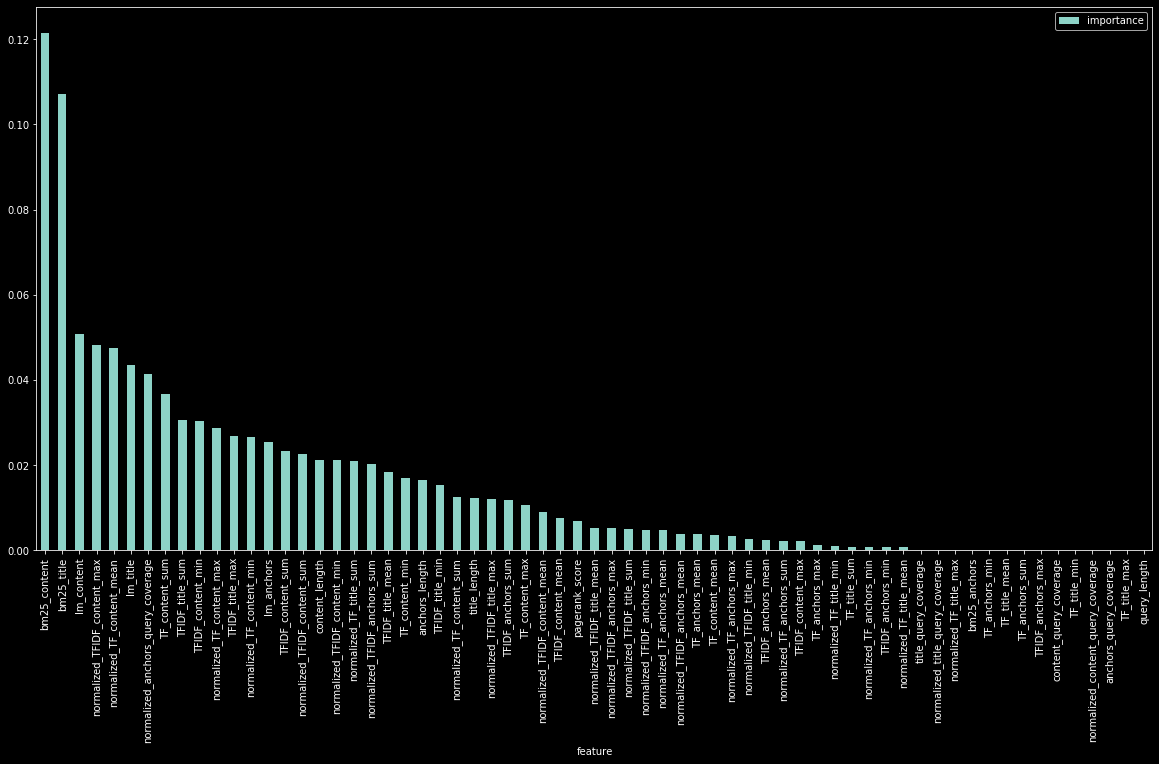

In [15]:
feature_importances = pd.DataFrame({'feature': full_feature_list, 'importance': model.regressor.feature_importances_})
feature_importances.set_index('feature', inplace=True)
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.plot(kind='bar', figsize=(20, 10))

## Identifying the optimal feature subset
To identify the optimal subset of features, we try training models with consecutive subsets of the most important features retrieved previously. We plot all the NDCG scores in the Evaluation part.

In [16]:
for n_features in tqdm(range(1, len(full_feature_list))):
    selected_features = feature_importances.iloc[:n_features].index.to_list()
    submodel = PointWiseLTRModel(train_data, selected_features)
    submodel.cross_validate(f'data/submodel_{str(n_features).zfill(2)}.csv')

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]


## Training our final model

In [20]:
# we identified the first 10 most important features yields the highest NDCG score
optimal_features = feature_importances.iloc[:11].index.to_list()
opti_model = PointWiseLTRModel(train_data, optimal_features)
opti_model.cross_validate(f'data/cross_validation.csv')
opti_model.rank(test_data, output='data/ranking_opti.csv')